# SYDE 552 Assignment 2: Vision
### Due Monday, February 19, 11:59pm
### Value: 15% of total marks for the course

This assignment covers the mammilian vision system, including both questions about the biology itself and constructing computational models based on Regression and Convolutional Neural Networks.

You can work in groups to do the assignment, but your answers and code must be original to you. Your submission will be a filled-out copy of this notebook (cells for code and written answers provided).

# 1. The Vision System

The purpose of this part of the assignment is to test your knowledge of the brain’s visual system and the relationship between neurobiological features and computational properties. The best answers will discuss both function and anatomy, and will draw on specific anatomical examples to support theoretical claims. You are encouraged to discuss answers with your classmates, consult the slides notes, or use external resources -- but your answers must be your own! In particular, read the Kandel et al. chapters listed on the slides. Expect to write around 5 sentences for each 1 point.

**1.a) [2 marks]** The neurons in different parts of the brain are sensitive to different things, and can be thought of as different feature detectors.  For each of the types of neurons listed below, describe what feature they detect, their receptive fields, and how their connectivity to other neurons and/or their internal neural processes helps them to do this feature detection:
- Cones
- Sustained Ganglion Cells
- Transient Ganglion Cells
- Simple Cells

*Cones*

Cones are responsible for colour vision and seeing finer detail during light conditions. There are three different types of cones which respond to different ranges of wavelengths thus each type of cone can be thought of as a feature detector which favours information within that range of wavelengths. Additionally, cones are laterally connected, leading to some lateral inhibition which increases their response to edges. Beyond this minimal processing, the cones are relatively simple photoreceptors, leaving most of the processing for later neurons.

*Sustained Ganglion Cells*

Ganglion cells have a center-surround pattern in their receptive field. For On cells, the firing rate increases with a stimulus in the center of the receptive field but would decrease from a stimulus at the outside of the receptive field (in OFF cells the pattern is reversed). The center-surround receptive field enhances edges and areas of contrast so these are the features which are favoured by this class of cells.
The sustained ganglion cells maintain a steady output for several seconds of stimulation meaning they don't favour novel stimuli to the same degree that transient ganglion cells do.

*Transient Ganglion Cells*

Transient ganglion cells have the same center-surround pattern as the sustained ganglion cells meaning they favour edges and contrast in the same way.
Differing from sustained ganglion cells, transient ganglion cells only fire at the beginning of a new stimulus so they emphasize rapidly changing or moving stimuli as features.

*Simple Cells*

Simple cells combine inputs from multiple ganglion cells to form on and off regions within their receptive field. These cells are specific to particular orientations so they briefly respond to bars of light that enter the on region. The orientation that a simple cell favours is a result of the spatial relationship between the ganglion cells that are connected to the simple cell. As such the feature that a simple cell favours is a stimulus aligned to that cell's orientation.

Sources: Kandel et al, Lecture Slides 

**1. b) [1 marks]** Describe two instances where retinotopic organization facilitates visual processing.  For each example, be sure to mention its anatomical location and discuss how retinitopy contributes to the feature detection.

In simple cells, ganglions from similar parts of the field of view are combined in order to provide sensitivity to particular orientations of stimulus. The spatial relationships between those ganglions are crucial for this layer of feature detection. In this case we see that the retinotropic helps form the features for the simple cells to respond to which can be combined to form higher level features. These simple cells are located in the visual cortex.

Additionally, disparity-selective neurons in the visual cortex combine the signals from the left and right eyes that correspond to the same locartion in the visual field, responding to particular amounts of temporal disparity which indicate a particular depth. In this case, the proximity of neurons which correspond to the same visual field location from different eyes help with depth perception in the visual process.

Sources: Kandel et al, Lecture Slides 

**1. c) [2 marks]** Discuss the similarities and differences between convolutional neural networks and the visual system.

*Similarities*

Local Receptive fields: In CNNs local inputs are pooled which mimics the local receptive field of a ganglion cell. As the signal goes through layers of the CNN, the receptive field for each neuron/perceptron grows which is similar to how the visual system handles more abstract representations as the signal continues from the retina through the visual cortex.

Translational Invariance: In both CNNs and the visual system, there are parts of the system which are selecrtive to particular features regardless of their position within the frame of view. In both cases the local pooling that occurs after a convolutional layer or in a ganglion or simple cell and the multi-stage processing allow for this property.

Hierarchy of features: In CNNs, layers are sensitive to features of increasing complexity as they proceed through the network. In a similar way, early in the visual system a ganglion cell may be sensitive to a particular orientation and later in the visual cortex there may be cells sensitive to more complex features. 

Learned features: In a CNN, the features are learned through the training off the model, an optimization method like gradient descent finds features which lead to strong model performance. In the visual system the features that early neurons respond to are learned during early stages of brain development.

*Differences*

Convolution: Convolution is very unlikely to be occuring in the brain, the saved constants and repeated computations don't have a likely biological mechanism so the visual system probably processes images in a  different manner from CNNs.

Neuron Adaptation: In the visual system there is neuron adaptation which doesn't occur in a CNN. The same unchanging stimulus will eventually stop triggering a response in the visual system whereas it would keep having the same output in a CNN.

Lateral Connections: CNNs don't traditionally have lateral connections, information tends to just feed forward in one direction. On the other hand, the visual system has lots more lateral connections for example photoreceptors have some lateral inhibition.

Sources: Kandel et al, Lecture Slides 

# 2. Classifying Stimuli Using Regression

The retina transforms the light entering an eye into a particular set of features, which are then sent to the rest of the brain for further processing.  In this section we look at how neurons might detect patterns, and how that detection changes with different feature detectors.

The data we will use for this is the classic MNIST dataset 

In [23]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

mnist = torchvision.datasets.MNIST(root='.', download=True)

The MNIST digits are 28x28 pixels each, each pixel is a value from 0 to 255, and there are 60,000 of them.  The raw data is in `mnist.data` and the target value (i.e. the actual digit) is in `mnist.targets`.  Here are the first 24 of each:

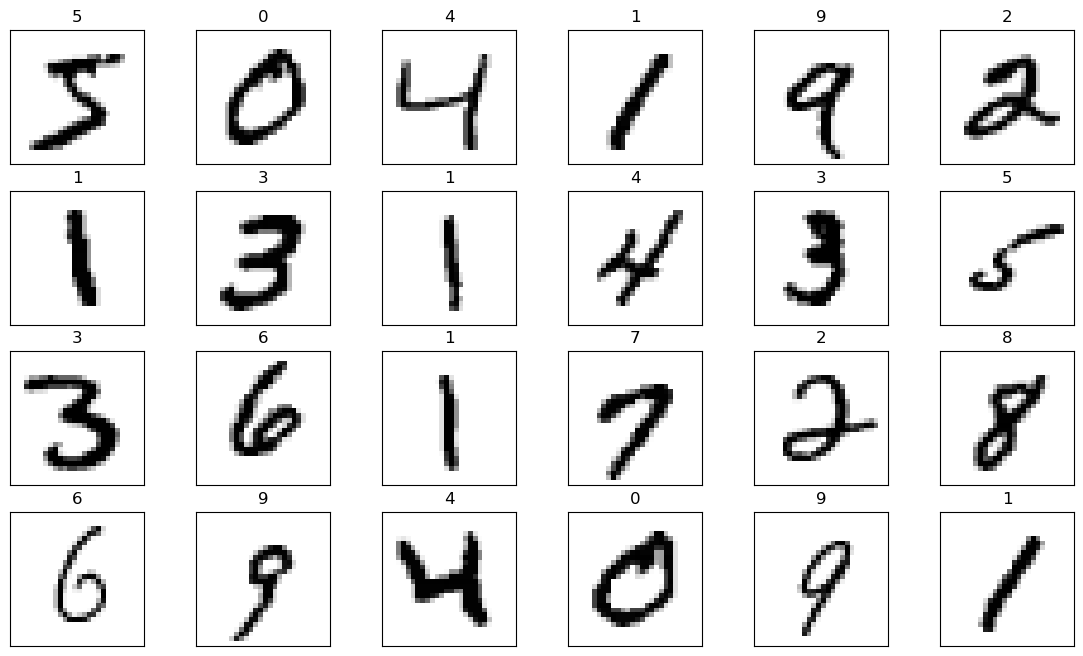

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(14,8))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(mnist.data[i], vmin=0, vmax=255, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title(int(mnist.targets[i]))

**2.a) [1 mark]** We can imagine the MNIST digits as 784 (28 times 28) input neurons.  We want to connect these 784 neurons to 10 output neurons, one for each digit, and see how accurately we can classify the digits.  

To find the weights in this question, we will use Ridge Regression.  `X` is the MNIST input data, divided by 255 to rescale it to between 0 and 1, and then reshaped to be a 60000x784 matrix

```
X = mnist.data.reshape((60000,28*28)).float()/255
```

The target data T is a "one-hot" representation of our outputs.  That is, instead of the desired output to be `5`, the output should be `[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]` and if the desired output should be `0`, that would be `[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]`.  

```
T = torch.nn.functional.one_hot(mnist.targets).float()
```

If our output is `Y=X @ W`, we need to find `W` such that `Y` is as close as possible to `T`.  For Ridge Regression, this is computed as

```
W = torch.inverse(X.T @ X + lambd*I) @ (X.T @ T)
```

where `I` is an identity matrix of the correct size (`torch.eye(784).float()`) and `lambd` is the $\lambda$ parameter that stops the regression from overfitting.

When building any sort of classifier model, we generally want to create the model using one set of data, and then test it on another set of data.  Here, we will use the first 5,000 data points for creating ("training") the model, and the other 55,000 for testing:

```
N = 5000
X_train, X_test = X[:N], X[N:]  # split X into two parts for training and testing
T_train, T_test = T[:N], T[N:]  # split T into two parts for training and testing
```

Given this data, you should find `W` using *only* the `X_train` and `T_train` data.  Once you find `W` you can apply it to the `X_train` and `X_test` to get `Y_train` and `Y_test`

```
Y_train = X_train @ W
Y_test = X_test @ W
```

Finally, you can compute the accuracy by determining when the output is the correct category.  Here we will do this by counting when the largest output value in each row in `Y` is at the same spot as the largest output value in each row in `T`:

```
accuracy_train = torch.sum(torch.argmax(Y_train, axis=1)==torch.argmax(T_train, axis=1))/len(Y_train)
accuracy_test = torch.sum(torch.argmax(Y_test, axis=1)==torch.argmax(T_test, axis=1))/len(Y_test)
```

- Compute the training and testing accuracy when $\lambda=1$ and we use the first 5,000 data points as for training (and test on the remaining 55,000).  Report both numbers.  
- Do we expect the testing accuracy to be larger or smaller than the training accuracy?  Why?


In [25]:
# calculate number of pixels
pix_num = 28*28
# Rescale images to 0-1
X = mnist.data.reshape((60000, pix_num)).float() / 255
# One-hot encode targets
T = torch.nn.functional.one_hot(mnist.targets).float()

# Split dataset into training and test sets
N = 5000
X_train, X_test = X[:N], X[N:]
T_train, T_test = T[:N], T[N:]

In [26]:
I = torch.eye(pix_num).float()
lambd = 1

In [27]:
def ridge_regression (X, T, lambd):
  I = torch.eye(pix_num).float()
  # Apply ridge regression to find the weights
  W = torch.inverse(X.T @ X + lambd * I) @ (X.T @ T)
  return W

In [28]:
def test (X, T, W):
  Y = X @ W
  accuracy = torch.sum(torch.argmax(Y, axis=1) == torch.argmax(T, axis=1)) / len(Y)
  return accuracy

In [29]:
# Train model with training data
W = ridge_regression(X_train, T_train, lambd)
# Test model performance on training data
accuracy_train = test(X_train, T_train, W)
# Test model performance on test data
accuracy_test = test(X_test, T_test, W)

print(f"Training accuracy: {accuracy_train:.3f}")
print(f"Test accuracy: {accuracy_test:.3f}")

Training accuracy: 0.903
Test accuracy: 0.819


We expect the testing accuracy to be smaller than the training accuracy. This is because the model is trained on the training data so it has been optimized to fit those data points. The testing data should be similar to the training data but it will have some differences which the model has not seen before.

We see this happen in the results above. The training accuracy is 0.903 while the test accuracy is just 0.819.

**2. b) [2 marks]**  Repeat part a) but vary the value of `lambd` from $10^{-5}$ to $10^5$.   You can use a `for` loop such as `for lambd in np.logspace(-5, 5, 11):`.  

- Generate a single plot that shows the training and testing accuracy.  Make sure to label your axes and the lines on the plot.  

- What is the best value for `lambd` (i.e. the value for which we get the best training accuracy).  
- Why does changing `lambd` affect the accuracy?  
- Why would having a large `lambd` value be good for making a biologically realistic model?

In [30]:
lambda_values = []
training_accuracies = []
test_accuracies = []

for lambd in np.logspace(-5, 5, 11):
  W = ridge_regression(X_train, T_train, lambd)
  accuracy_train = test(X_train, T_train, W)
  accuracy_test = test(X_test, T_test, W)
  training_accuracies.append(accuracy_train)
  test_accuracies.append(accuracy_test)
  lambda_values.append(lambd)

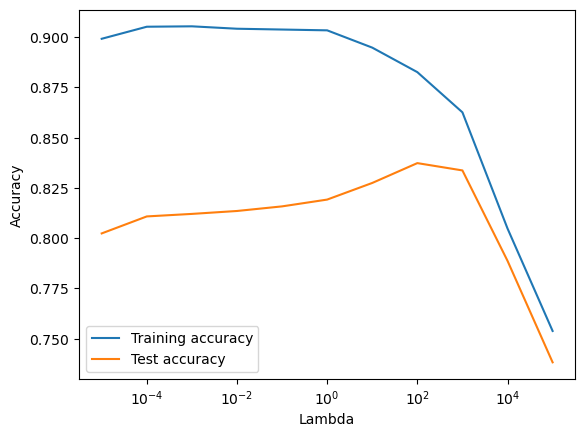

In [31]:
plt.figure()
plt.plot(lambda_values, training_accuracies, label='Training accuracy')
plt.plot(lambda_values, test_accuracies, label='Test accuracy')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
# Find the best lambda for training and test values
best_lambda = lambda_values[np.argmax(test_accuracies)]
print(f"Best lambda for test: {best_lambda:.3f}")
print(f"Best test accuracy: {max(test_accuracies):.3f}")

best_lambda = lambda_values[np.argmax(training_accuracies)]
print(f"Best lambda for training: {best_lambda:.3f}")
print(f"Best training accuracy: {max(training_accuracies):.3f}")

Best lambda for test: 100.000
Best test accuracy: 0.837
Best lambda for training: 0.001
Best training accuracy: 0.905


The best value for lambda varied between training and test performance. The best value for training accuracy was 0.001 while the best value for test accuracy was 100. The test performance is more valuable because it better captures the model's ability to generalize to data outside of it's training data.

Changing lambd changes the accuracy because it affects the amount of regularization in the ridge regression. The lambd parameter penalizes large weights which serves to prevent the model from overfitting on the training data.

We see that a larger lambda value (ie. 100) improves the test accuracy even though the training accuracy suffers. This suggests that the model is generalizing better.

Having a large lamd value is more biologically realistic because it should prevent the weights from growing too large. In the computer model, the weights can increase arbitrarily but in the brain

**2. c) [1 mark]** The input we have used so far is not very realistic.  In real life, when we see written digits, they are under a wide range of lighting conditions. For this question, we change `X` by scaling it randomly and adding a random background brightness.

```
X = mnist.data.reshape((60000,28*28)).float()/255
X = X*(1-2*torch.rand(60000)[:,None]) + torch.rand(60000)[:,None]
```

To see what this looks like, here is how you can plot it:

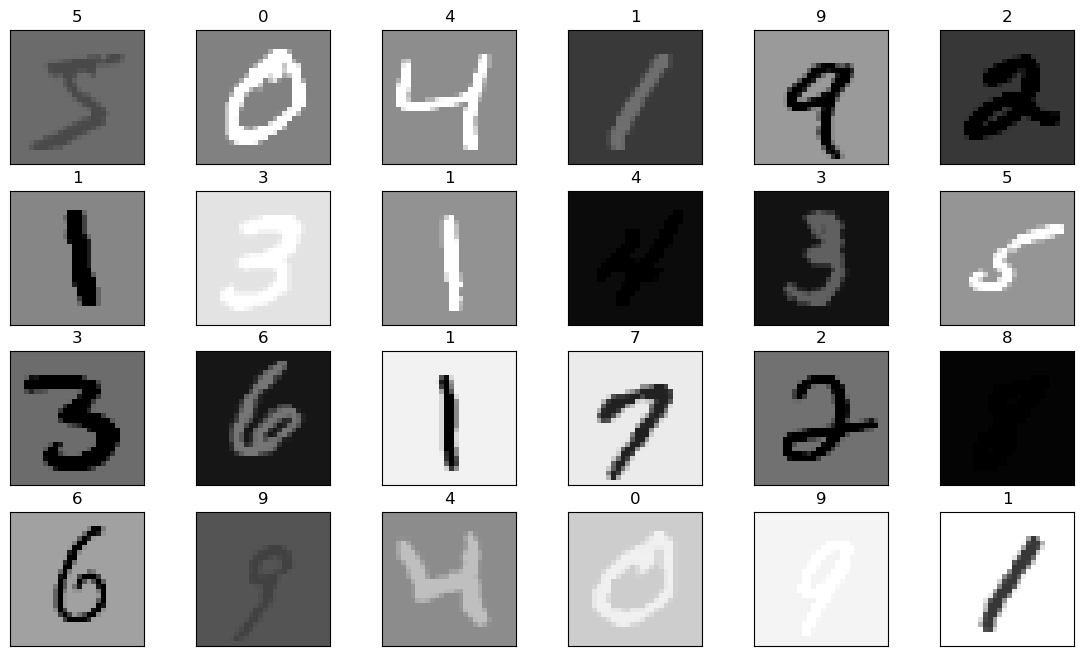

In [33]:
X_aug = mnist.data.reshape((60000,28*28)).float()/255
X_aug = X_aug*(1-2*torch.rand(60000))[:,None] + torch.rand(60000)[:,None]

plt.figure(figsize=(14,8))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(X_aug[i].reshape(28,28), vmin=0, vmax=1, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title(int(mnist.targets[i]))


- Generate the same plot as in 2b) but for this new dataset.  
- Is this a harder or easier task than with the original dataset?
- Is this new dataset more like the data at the retina or like the data in the ganglion cells?
- Is the original dataset more like the data at the retina or like the data in the ganglion cells?

In [34]:
# Split augmented dataset into training and test sets
N = 5000
X_aug_train, X_aug_test = X_aug[:N], X_aug[N:]
T_train, T_test = T[:N], T[N:]

In [35]:
lambda_values = []
training_accuracies = []
test_accuracies = []

# Note: I was not able to invert the matrix with a lambda of 10^-5, so I started at 10^-4
for lambd in np.logspace(-4, 5, 11):
  W = ridge_regression(X_aug_train, T_train, lambd)
  accuracy_train = test(X_aug_train, T_train, W)
  accuracy_test = test(X_aug_test, T_test, W)
  training_accuracies.append(accuracy_train)
  test_accuracies.append(accuracy_test)
  lambda_values.append(lambd)

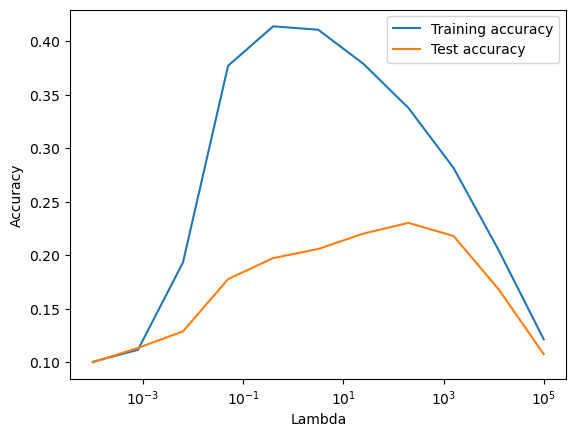

In [36]:
plt.figure()
plt.plot(lambda_values, training_accuracies, label='Training accuracy')
plt.plot(lambda_values, test_accuracies, label='Test accuracy')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [37]:
best_lambda = lambda_values[np.argmax(test_accuracies)]
print(f"Best lambda for test: {best_lambda:.3f}")
print(f"Best test accuracy: {max(test_accuracies):.3f}")

Best lambda for test: 199.526
Best test accuracy: 0.230


This is a much harder task than the original dataset, we see that the max accuracy achieved is much lower than the performance with the original dataset.

The new dataset is more like the data at the retina as it has a variety of lighting conditions like the raw information which hits the retina.

The original dataset is more like the data at the ganglion because it has consistent lighting conditions, by the ganglion visual information has been normalized so that processing is less sensitive to external conditions.

**2. d) [1 mark]** We can think of neurons in the visual system as transforming the data in various ways.  Given the dataset in 2c), neurons might be able to transform it to look more like the origin data.

Here are three data transformations that could be applied here:

Subtracting the Mean
```
X = X-torch.mean(X, axis=1)[:,None]
```

Absolute value
```
X = torch.abs(X)
```

Normalizing
```
X = X/torch.linalg.norm(X, axis=1)[:,None]
```

- Apply all three of them (in the order shown above) to the dataset and generate the same graph as in 2b) and 2c).
- How does the performance of the network compare to that of 2b) and 2c)?
- Do any of the three transformations above correspond to processing that occurs in the eye before the signal is sent to the rest of the brain?
- Given this result, why does the eye transform the data between raw rods & cones and the ganglion cells?

In [38]:
X_transformed = X_aug - torch.mean(X_aug, axis=1)[:,None]
X_transformed = torch.abs(X_transformed)
X_transformed = X_transformed / torch.linalg.norm(X_transformed, axis=1)[:,None]

In [39]:
# Split transformed dataset into training and test sets
N = 5000
X_transformed_train, X_transformed_test = X_transformed[:N], X_transformed[N:]
T_train, T_test = T[:N], T[N:]

In [40]:
lambda_values = []
training_accuracies = []
test_accuracies = []

# Note: I was not able to invert the matrix with a lambda of 10^-5, so I started at 10^-4
for lambd in np.logspace(-5, 5, 11):
  W = ridge_regression(X_transformed_train, T_train, lambd)
  accuracy_train = test(X_transformed_train, T_train, W)
  accuracy_test = test(X_transformed_test, T_test, W)
  training_accuracies.append(accuracy_train)
  test_accuracies.append(accuracy_test)
  lambda_values.append(lambd)

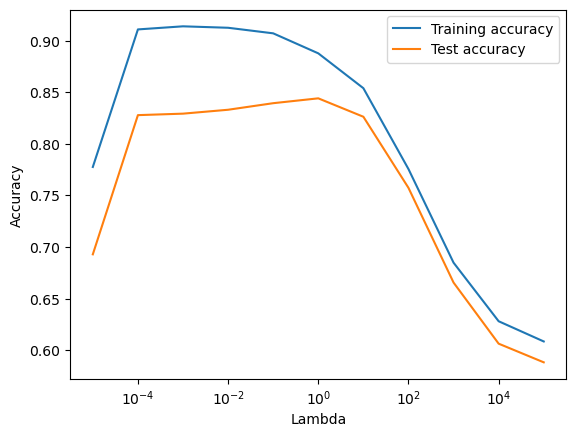

In [41]:
plt.figure()
plt.plot(lambda_values, training_accuracies, label='Training accuracy')
plt.plot(lambda_values, test_accuracies, label='Test accuracy')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [42]:
best_lambda = lambda_values[np.argmax(test_accuracies)]
print(f"Best lambda for test: {best_lambda:.3f}")
print(f"Best test accuracy: {max(test_accuracies):.3f}")

Best lambda for test: 1.000
Best test accuracy: 0.844


The performance of the model with the transformed data is much better than performance with the augmented data in 2c, it is similar to the performance with the original data in 2b.

The step of subtracting the mean corresponds to the retinal process of light adaptation because it is reducing the imnpact of the overall scene's illumination.

Based on this result it makes sense that the eye tranforms information before the ganglion cells because it makes it easier to recognize the visual contents when the effects of lighting conditions have been removed or at least reduced.

# 3. Classifying Stimuli Using Backpropogation

Regression is restricted to learning the layer of weights that produces the final output.  If we want to also learn what features are most useful for producing that output, we need a more complex learning rule, and this is typically backpropogation.  Here we will classify the same data as in question 2, and we will build up different network structures to do so.

Backpropogation tends to work best when learning on a bunch of data at the same time (a "batch").  The following code will set up the same training and testing data as in question 2, but presented in randomized batches of 1000 at a time.

```python
mnist = torchvision.datasets.MNIST(root='.', download=True, transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000)), 
                                           batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000, 10000)), 
                                          batch_size=1000, shuffle=True)
```

In [43]:
# Setup dataloaders for MNIST
mnist = torchvision.datasets.MNIST(root='.', download=True, transform=torchvision.transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000)), batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000, 10000)), batch_size=1000, shuffle=True)


To create a neural network, we need to define what the weights are we will learn and we need to define the computation that the network will perform.  Here is the definition of a simple network that has an input of 784 values (the MNIST inputs), which go to 50 "hidden"-layer neurons, and then to the output 10 neurons.  So the network will learn to transform the 784 inputs into 50 new representations, and from those 50 features it will learn weights to create an output of 10 values (our 10 categories).  This is known as a multi-layer perceptron, or a standard neural network with a single hidden layer.

```python
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # these will be learned
        self.fc1 = nn.Linear(784, 50)   # the weights from the input to the new learned features (hidden layer)
        self.fc2 = nn.Linear(50, 10)    # the weights from the hidden layer to the output

    def forward(self, x):
        # the processing the network will do
        x = x.view(-1, 784)             # flatten the input from 28x28 to 784 values
        x = F.relu(self.fc1(x))         # apply the first set of weights, then apply the ReLU neuron model
        x = self.fc2(x)                 # apply the second set of weights
        return F.log_softmax(x)         # apply a softmax function as we just want one large output indicating category
    
network = Net()
```

Finally, we need to train our model.  When training, it is useful to keep track of how well the model is doing on the testing data.  Since testing the network takes time, we don't necessarily want to do it all the time.  Instead, the following code trains the network 10 times, and then records how well the network does on the training data and on the testing data.

In [44]:
# Define neural network class
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(784, 50)
    self.fc2 = nn.Linear(50, 10)
  
  def forward (self, x):
    x = x.view(-1, 784)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x)
  
network = Net()

In [45]:
# create the learning rule
optimizer = optim.SGD(network.parameters(), 
                      lr=0.1,   # learning rate
                      momentum=0.5)

# variables to keep track of the training and testing accuracy
accuracy_train = []
accuracy_test = []

def continue_training():
    network.train()      # configure the network for training
    for i in range(10):  # train the network 10 times
        correct = 0
        for data, target in train_loader:       # working in batchs of 1000
            optimizer.zero_grad()               # initialize the learning system
            output = network(data)              # feed in the data 
            loss = F.nll_loss(output, target)   # compute how wrong the output is
            loss.backward()                     # change the weights to reduce error
            optimizer.step()                    # update the learning rule
            
            pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest
            correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs
    # update the list of training accuracy values
    score = float(correct/len(train_loader.dataset))
    accuracy_train.append(score)
    print('Iteration', len(accuracy_train), 'Training accuracy:', score)
    
    correct = 0
    network.eval()
    for data, target in test_loader:    # go through the test data once (in groups of 1000)
        output = network(data)                               # feed in the data
        pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest
        correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs
    # update the list of testing accuracy values
    score = float(correct/len(test_loader.dataset))
    accuracy_test.append(score)
    print('Iteration', len(accuracy_test), 'Testing accuracy:', score)


Given the above code, you can train your network 10 times by doing

```python
for i in range(10):
    continue_training()
```

If you want to continue training even more, you can just run that `for` loop again.

To plot the final accuracy results, you can use

```python
plt.figure(figsize=(12,4))
plt.plot(accuracy_train, label='training')
plt.plot(accuracy_test, label='testing')
plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.show()
```

**3. a) [1 mark]** Run the model above for 10 iterations (i.e. call `continue_training` 10 times).

- Plot the training and testing accuracy.  
- Is this model better or worse than the best models developed in question 2?

In [46]:
for i in range(10):
  continue_training()

/var/folders/2s/9hjjm87j7ldc54rw3_f_pfcm0000gn/T/ipykernel_21921/2942850101.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Iteration 1 Training accuracy: 0.8626000285148621
Iteration 1 Testing accuracy: 0.8564000129699707
Iteration 2 Training accuracy: 0.8988000154495239
Iteration 2 Testing accuracy: 0.8835999965667725
Iteration 3 Training accuracy: 0.9136000275611877
Iteration 3 Testing accuracy: 0.8960000276565552
Iteration 4 Training accuracy: 0.9218000173568726
Iteration 4 Testing accuracy: 0.9003999829292297
Iteration 5 Training accuracy: 0.9277999997138977
Iteration 5 Testing accuracy: 0.9049999713897705
Iteration 6 Training accuracy: 0.9359999895095825
Iteration 6 Testing accuracy: 0.9046000242233276
Iteration 7 Training accuracy: 0.9399999976158142
Iteration 7 Testing accuracy: 0.9075999855995178
Iteration 8 Training accuracy: 0.9453999996185303
Iteration 8 Testing accuracy: 0.9093999862670898
Iteration 9 Training accuracy: 0.9490000009536743
Iteration 9 Testing accuracy: 0.9100000262260437
Iteration 10 Training accuracy: 0.9520000219345093
Iteration 10 Testing accuracy: 0.9110000133514404


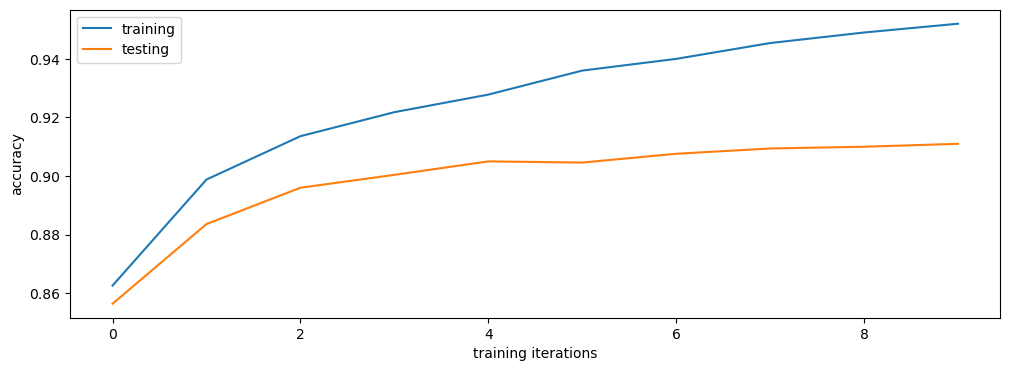

In [47]:
plt.figure(figsize=(12,4))
plt.plot(accuracy_train, label='training')
plt.plot(accuracy_test, label='testing')
plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.show()

In [48]:
best_testing_accuracy = np.argmax(accuracy_test)

print(f"Best testing accuracy: {accuracy_test[best_testing_accuracy]:.3f}")

Best testing accuracy: 0.911


This model is better than the best models developed in question 2, the test accuracy reaches 0.911 whereas the best performance seen in q2 was 0.844.

**3. b) [1 mark]** Repeat question 3a five times.  This does not mean to run a single model for 50 iterations.  Rather, you need to reset the model and train it again.  The easiest way to do this is to recreate the network and the optimizer like this:

```python
network = Net()
optimizer = optim.SGD(network.parameters(), 
                      lr=0.1,
                      momentum=0.5)
```

- Make a plot showing the 5 different training accuracies and 5 different testing accuracies
- Also show the average training and testing accuracy on the plot.
- Each of the 5 models should show slightly different accuracies.  Why is this the case?


In [29]:
accuracy_train_runs = []
accuracy_test_runs = []

for i in range(5):
  network = Net()
  optimizer = optim.SGD(network.parameters(), lr=0.1, momentum=0.5)
  accuracy_train = []
  accuracy_test = []
  for i in range(10):
    continue_training()
  accuracy_train_runs.append(accuracy_train)
  accuracy_test_runs.append(accuracy_test)

/var/folders/2s/9hjjm87j7ldc54rw3_f_pfcm0000gn/T/ipykernel_91646/2942850101.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Iteration 1 Training accuracy: 0.8661999702453613
Iteration 1 Testing accuracy: 0.8633999824523926
Iteration 2 Training accuracy: 0.9017999768257141
Iteration 2 Testing accuracy: 0.8876000046730042
Iteration 3 Training accuracy: 0.9151999950408936
Iteration 3 Testing accuracy: 0.8971999883651733
Iteration 4 Training accuracy: 0.9225999712944031
Iteration 4 Testing accuracy: 0.9010000228881836
Iteration 5 Training accuracy: 0.9291999936103821
Iteration 5 Testing accuracy: 0.9035999774932861
Iteration 6 Training accuracy: 0.9362000226974487
Iteration 6 Testing accuracy: 0.907800018787384
Iteration 7 Training accuracy: 0.9405999779701233
Iteration 7 Testing accuracy: 0.9071999788284302
Iteration 8 Training accuracy: 0.9449999928474426
Iteration 8 Testing accuracy: 0.909600019454956
Iteration 9 Training accuracy: 0.9472000002861023
Iteration 9 Testing accuracy: 0.909600019454956
Iteration 10 Training accuracy: 0.9513999819755554
Iteration 10 Testing accuracy: 0.9111999869346619
Iteration 1

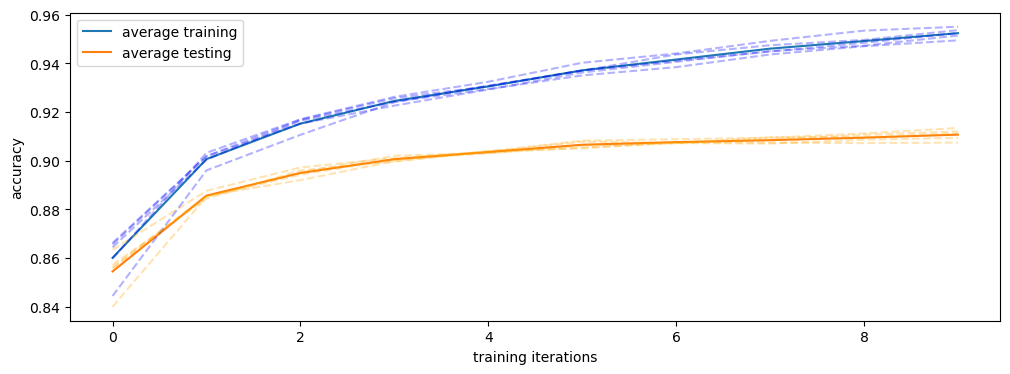

In [36]:
average_accuracy_train = np.mean(accuracy_train_runs, axis=0)
average_accuracy_test = np.mean(accuracy_test_runs, axis=0)
plt.figure(figsize=(12,4))
plt.plot(average_accuracy_train, label='average training')
plt.plot(average_accuracy_test, label='average testing')

for i in range(5):
  plt.plot(accuracy_train_runs[i], color='blue', alpha=0.3, linestyle='--')
  plt.plot(accuracy_test_runs[i], color='orange', alpha=0.3, linestyle='--')

plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.show()

Each training run has slightly different results because the initial weights are randomly generated so the model starts in a different place each run. Additionally, the model sees the data in a different order each run.

**3. c) [1 mark]** Repeat question 3b varying the number of neurons in the hidden layer of the network.  The current value is 50.  Try it with 5, 10, 20, 50, and 100 neurons.  For each number of neurons, repeat five times and take the average (like in question 3b).  

- Plot the final testing accuracy on the y-axis and the number of neurons on the x-axis.  Note that to speed things up you can remove the testing computation from continue_training until the very end, since we only need the final testing score.


In [37]:
# Redefine neural net class to include hidden layer size as a parameter
class Net(nn.Module):
  def __init__(self, hidden_size):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(784, hidden_size)
    self.fc2 = nn.Linear(hidden_size, 10)
  
  def forward (self, x):
    x = x.view(-1, 784)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x)

In [40]:
def continue_training():
  network.train()      # configure the network for training
  for i in range(10):  # train the network 10 times
      correct = 0
      for data, target in train_loader:       # working in batchs of 1000
          optimizer.zero_grad()               # initialize the learning system
          output = network(data)              # feed in the data 
          loss = F.nll_loss(output, target)   # compute how wrong the output is
          loss.backward()                     # change the weights to reduce error
          optimizer.step()                    # update the learning rule
          
          pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest
          correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs

In [41]:
def test_network():
  correct = 0
  network.eval()
  for data, target in test_loader:    # go through the test data once (in groups of 1000)
      output = network(data)                               # feed in the data
      pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest
      correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs
  # update the list of testing accuracy values
  score = float(correct/len(test_loader.dataset))
  accuracy_test.append(score)
  print('Testing accuracy:', score)

In [43]:
hidden_layer_sizes = [5, 10, 20, 50, 100]
final_accuracies = []

for hidden_layer_size in hidden_layer_sizes:
  accuracy_test_runs = []
  for i in range(5):
    network = Net(hidden_layer_size)
    optimizer = optim.SGD(network.parameters(), lr=0.1, momentum=0.5)
    accuracy_train = []
    accuracy_test = []
    for j in range(10):
      continue_training()
    test_network()
    print(f"Hidden layer size: {hidden_layer_size}, Run: {i+1}")
    print(f"Test accuracy: {accuracy_test[-1]:.3f}")
    accuracy_test_runs.append(accuracy_test[-1])
  average_accuracy_test = np.mean(accuracy_test_runs)
  print(f"Hidden layer size: {hidden_layer_size}, Test accuracy: {average_accuracy_test:.3f}")
  final_accuracies.append(average_accuracy_test)


/var/folders/2s/9hjjm87j7ldc54rw3_f_pfcm0000gn/T/ipykernel_91646/844108529.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Testing accuracy: 0.8288000226020813
Hidden layer size: 5, Run: 1
Test accuracy: 0.829
Testing accuracy: 0.8697999715805054
Hidden layer size: 5, Run: 2
Test accuracy: 0.870
Testing accuracy: 0.8456000089645386
Hidden layer size: 5, Run: 3
Test accuracy: 0.846
Testing accuracy: 0.8525999784469604
Hidden layer size: 5, Run: 4
Test accuracy: 0.853
Testing accuracy: 0.8525999784469604
Hidden layer size: 5, Run: 5
Test accuracy: 0.853
Hidden layer size: 5, Test accuracy: 0.850
Testing accuracy: 0.8988000154495239
Hidden layer size: 10, Run: 1
Test accuracy: 0.899
Testing accuracy: 0.9017999768257141
Hidden layer size: 10, Run: 2
Test accuracy: 0.902
Testing accuracy: 0.9038000106811523
Hidden layer size: 10, Run: 3
Test accuracy: 0.904
Testing accuracy: 0.8981999754905701
Hidden layer size: 10, Run: 4
Test accuracy: 0.898
Testing accuracy: 0.8996000289916992
Hidden layer size: 10, Run: 5
Test accuracy: 0.900
Hidden layer size: 10, Test accuracy: 0.900
Testing accuracy: 0.9052000045776367
H

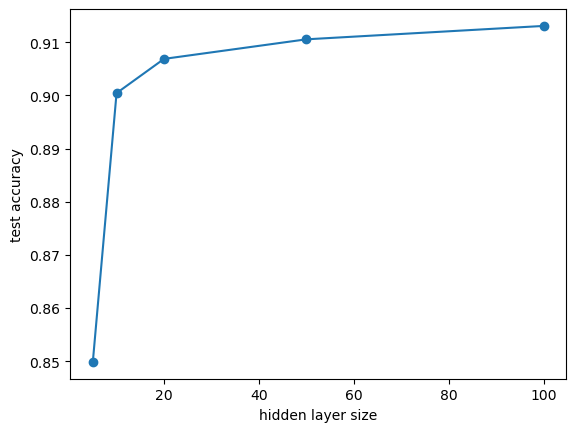

In [47]:
plt.figure()
plt.plot(hidden_layer_sizes, final_accuracies)
plt.scatter(hidden_layer_sizes, final_accuracies)
plt.xlabel('hidden layer size')
plt.ylabel('test accuracy')
plt.show()

**3. d) [2 marks]** Now we will add a convolution layer to our network.  The following network adds two convolution layers before two normal neural network layers.

```python
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=5)  # set the size of the convolution to 5x5, and have 12 of them
        self.conv2 = nn.Conv2d(12, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # make sure to do max pooling after the convolution layers
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)
```

The following code can be used to plot the learned features in the first layer:
```python
plt.figure(figsize=(12,5))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(network.conv1.weight[i][0].detach().numpy(), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
plt.show()
```

- Train the model through 40 iterations and generate a plot of training and testing accuracy over time.
- Does this perform better or worse than the previous models in this assignment?
- What advantages and disadvantages do you see with this approach (in comparison to the previous parts of the assignment)?
- Plot the features learned by the first convolution layer.  How do they compare to real features detected in the V1 area of the brain?

In [50]:
# Add convolutional layer to network
class Conv_Net(Net):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 12, kernel_size=5)  # set the size of the convolution to 5x5, and have 12 of them
    self.conv2 = nn.Conv2d(12, 20, kernel_size=5)
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))  # make sure to do max pooling after the convolution layers
    x = F.relu(F.max_pool2d(self.conv2(x), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x)

In [51]:
network = Conv_Net()
optimizer = optim.SGD(network.parameters(), lr = 0.1, momentum=0.5)
accuracy_train = []
accuracy_test = []

def continue_training():
    network.train()      # configure the network for training
    for i in range(10):  # train the network 10 times
        correct = 0
        for data, target in train_loader:       # working in batchs of 1000
            optimizer.zero_grad()               # initialize the learning system
            output = network(data)              # feed in the data 
            loss = F.nll_loss(output, target)   # compute how wrong the output is
            loss.backward()                     # change the weights to reduce error
            optimizer.step()                    # update the learning rule
            
            pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest
            correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs
    # update the list of training accuracy values
    score = float(correct/len(train_loader.dataset))
    accuracy_train.append(score)
    print('Iteration', len(accuracy_train), 'Training accuracy:', score)
    
    correct = 0
    network.eval()
    for data, target in test_loader:    # go through the test data once (in groups of 1000)
        output = network(data)                               # feed in the data
        pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest
        correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs
    # update the list of testing accuracy values
    score = float(correct/len(test_loader.dataset))
    accuracy_test.append(score)
    print('Iteration', len(accuracy_test), 'Testing accuracy:', score)

In [52]:
for i in range(40):
  continue_training()

/var/folders/2s/9hjjm87j7ldc54rw3_f_pfcm0000gn/T/ipykernel_91646/2395503021.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Iteration 1 Training accuracy: 0.7390000224113464
Iteration 1 Testing accuracy: 0.7523999810218811
Iteration 2 Training accuracy: 0.9412000179290771
Iteration 2 Testing accuracy: 0.9247999787330627
Iteration 3 Training accuracy: 0.965399980545044
Iteration 3 Testing accuracy: 0.946399986743927
Iteration 4 Training accuracy: 0.9746000170707703
Iteration 4 Testing accuracy: 0.9422000050544739
Iteration 5 Training accuracy: 0.9783999919891357
Iteration 5 Testing accuracy: 0.9517999887466431
Iteration 6 Training accuracy: 0.9869999885559082
Iteration 6 Testing accuracy: 0.954200029373169
Iteration 7 Training accuracy: 0.9914000034332275
Iteration 7 Testing accuracy: 0.9598000049591064
Iteration 8 Training accuracy: 0.9936000108718872
Iteration 8 Testing accuracy: 0.9638000130653381
Iteration 9 Training accuracy: 0.995199978351593
Iteration 9 Testing accuracy: 0.9628000259399414
Iteration 10 Training accuracy: 0.9972000122070312
Iteration 10 Testing accuracy: 0.9629999995231628
Iteration 11

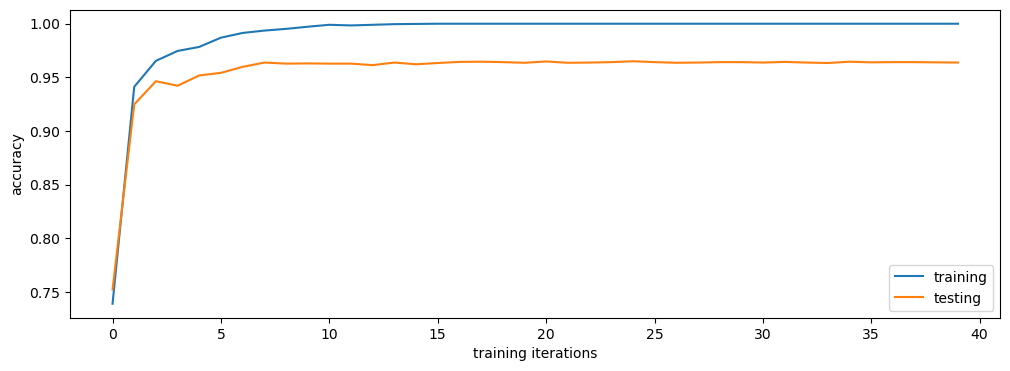

In [53]:
plt.figure(figsize=(12,4))
plt.plot(accuracy_train, label='training')
plt.plot(accuracy_test, label='testing')
plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.show()

This model performs better than all of the previous models in the assignment which is a large advantage over the previous approaches. Additionally, inspecting the features in each convolutional layer offers some degree of interpretability which is missing in the previous models. 
A disadvantage of this approach is that the CNN has more parameters and as such takes more training iterations to reach it's best performance. (Although the 40 iterations shown above are not necessary).

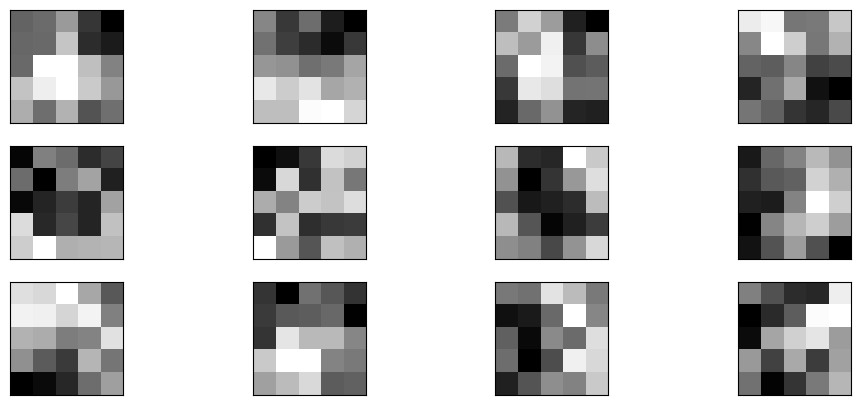

In [54]:
# Plot the features learned by the first convolutional layer
plt.figure(figsize=(12,5))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(network.conv1.weight[i][0].detach().numpy(), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
plt.show()

The real features in the V1 area of the brain are mainly particular orientations which correspond to different simple cells as described above. In the features plotted above we see some variation in orientation but overall the features are very noisy and hard to describe.

**BONUS [1 mark]** Try to improve the neural network.  You want to get the best testing accuracy you can.  Try at least two different approaches and report your results.